In [29]:
# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import shap
import pickle

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import tqdm

In [4]:
import pandas as pd
import numpy as np

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
class Linear(nn.Module):
    def __init__(self, weights,bias):
        super(Linear, self).__init__()
        self.weights = weights
        self.bias = bias        
    
    def forward(self, x):
        y = torch.matmul(x,self.weights)+self.bias
        return y

In [7]:
def min_max_normalization(df,col_name):
    min_val = df[col_name].min()
    max_val = df[col_name].max()
    df[col_name] = (df[col_name]-min_val)/(max_val-min_val)
    return df

In [8]:
def conterfactual_infer(query_x,target_y,feature_ids, model, loss_fn, max_iters):
    model.eval()
    tqdm_range = tqdm.tqdm(range(max_iters))
    cx = torch.clone(query_x)
    cx.requires_grad = True
    cf_optimizer = torch.optim.Adam([cx], lr=0.01)
    mask = torch.ones_like(query_x).type(torch.bool)
    mask[:,feature_ids] = False

    for it in tqdm_range:
        cy = model(cx)
        loss = loss_fn(cy,target_y)#loss_fn(query_x,cx,cy,target_y,feature_ids)
        loss.backward()
        cx.grad[mask]=0.
        cf_optimizer.step()
        cf_optimizer.zero_grad()

        if (it+1)%10 == 0:    
            tqdm_range.write('iter: {}, loss: {}'.format(it+1, loss.detach()))
    return cx, model(cx)

In [46]:
def query_recommendation(query_x,target_y,model,query_features,max_iters=200):
    
    if len(query_x.shape)==1:
        query_x = query_x.reshape(1,-1)
    if not isinstance(query_x,torch.Tensor):
        query_x = torch.Tensor(query_x)
        
    query_y = model(query_x)
    feature_ids = [feature_map[s] for s in query_features ]
    print(feature_ids)
    loss_fn = torch.nn.MSELoss(reduction='mean')
    
    cx,cy = conterfactual_infer(query_x,target_y,feature_ids, model, loss_fn, max_iters)
    
    diff = torch.abs(query_x-cx).reshape(-1)
    

    cf = features[diff>0]
    
    return cx,cy,cf

In [35]:
dataset = pd.read_csv("../data/trial_static_data.csv")
dataset.head()

,n_participant,duration,age>65,male,ethnicity_white,use_technology,medication,follow_up_considered,use_wearables,use_mobile_app,...,feedback_provided,prioir_treatment_history_considered,co_mobidities_considered,treatment_type,biosamples_collected,randomised,mutli_site,adverse_event_considered,support_sessions,retention_rate
0,11550.0,418.0,0.269070,0.349416,0.521052,yes,Testosterone,yes,no,no,...,yes,no,yes,behavioural,no,yes,no,yes,yes,0.532
1,60926.0,56.0,0.355991,0.461932,0.437640,no,Testosterone,yes,yes,yes,...,no,yes,yes,behavioural,yes,yes,yes,yes,yes,0.894
2,13382.0,373.0,0.404902,0.304780,0.819994,yes,5ARI,yes,yes,yes,...,yes,no,yes,behavioural,no,yes,no,no,yes,0.577
3,24097.0,183.0,0.264093,0.620426,0.824459,yes,venlafaxine,yes,no,no,...,yes,yes,yes,medication,yes,no,yes,yes,yes,0.767
4,32748.0,182.0,0.114587,0.412570,0.702339,no,citalopram,yes,yes,yes,...,no,yes,no,rTMS,no,no,no,no,yes,0.768


In [11]:
continuous = ["n_participant","duration","age>65","male","ethnicity_white","retention_rate"]
categorical = dataset.columns.difference(continuous)

In [12]:
one_hot_encoded = pd.get_dummies(dataset[categorical])
df_encoded = pd.concat([dataset.drop(categorical,axis=1), one_hot_encoded], axis=1)
df_encoded = min_max_normalization(df_encoded,["n_participant","duration"])

In [32]:
df_encoded.head()

,n_participant,duration,age>65,male,ethnicity_white,retention_rate,adverse_event_considered_no,adverse_event_considered_yes,biosamples_collected_no,biosamples_collected_yes,...,treatment_type_behavioural,treatment_type_medication,treatment_type_observational,treatment_type_rTMS,use_mobile_app_no,use_mobile_app_yes,use_technology_no,use_technology_yes,use_wearables_no,use_wearables_yes
0,0.115041,0.834677,0.269070,0.349416,0.521052,0.532,0,1,1,0,...,1,0,0,0,1,0,0,1,1,0
1,0.609063,0.104839,0.355991,0.461932,0.437640,0.894,0,1,0,1,...,1,0,0,0,0,1,1,0,0,1
2,0.133371,0.743952,0.404902,0.304780,0.819994,0.577,1,0,1,0,...,1,0,0,0,0,1,0,1,0,1
3,0.240578,0.360887,0.264093,0.620426,0.824459,0.767,0,1,0,1,...,0,1,0,0,1,0,0,1,1,0
4,0.327133,0.358871,0.114587,0.412570,0.702339,0.768,1,0,1,0,...,0,0,0,1,0,1,1,0,0,1


In [14]:
target = dataset["retention_rate"]
train_dataset, test_dataset, y_train, y_test = train_test_split(df_encoded,
                                                                target,
                                                                test_size=0.2,
                                                                random_state=0,
                                                                )
x_train = train_dataset.drop('retention_rate', axis=1)
x_test = test_dataset.drop('retention_rate', axis=1)


In [15]:
features = x_train.columns
feature_map = {}
for i,f in enumerate(features):
    feature_map[f]=i

In [49]:
features

Index(['n_participant', 'duration', 'age>65', 'male', 'ethnicity_white',
       'adverse_event_considered_no', 'adverse_event_considered_yes',
       'biosamples_collected_no', 'biosamples_collected_yes',
       'co_mobidities_considered_no', 'co_mobidities_considered_yes',
       'feedback_provided_no', 'feedback_provided_yes',
       'follow_up_considered_no', 'follow_up_considered_yes',
       'interviews_needed_no', 'interviews_needed_yes', 'medication_5ARI',
       'medication_Antidepressant', 'medication_Escitalopram',
       'medication_Testosterone', 'medication_citalopram',
       'medication_venlafaxine', 'mutli_site_no', 'mutli_site_yes',
       'prioir_treatment_history_considered_no',
       'prioir_treatment_history_considered_yes', 'questionare_completed_no',
       'questionare_completed_yes', 'randomised_no', 'randomised_yes',
       'support_sessions_no', 'support_sessions_yes',
       'treatment_type_behavioural', 'treatment_type_medication',
       'treatment_type_o

In [16]:
lrg = LinearRegression()
lrg.fit(x_train,y_train)

LinearRegression()

In [17]:
pred_y = lrg.predict(x_test)
score = mean_absolute_error(y_test,pred_y)
score

2.899902540320909e-16

In [18]:
lrg.coef_,lrg.intercept_

(array([ 4.04053006e-16, -4.96000000e-01, -2.20309881e-16, -2.74086309e-16,
        -7.80625564e-17,  1.90129430e-02,  1.90129430e-02, -7.56888161e-03,
        -7.56888161e-03, -5.75736042e-04, -5.75736042e-04,  7.71141180e-05,
         7.71141180e-05, -3.46238238e-02, -3.46238238e-02, -2.31814262e-03,
        -2.31814262e-03, -7.10461922e-04, -7.10461922e-04, -7.10461922e-04,
        -7.10461922e-04, -7.10461922e-04, -7.10461922e-04, -3.38294688e-03,
        -3.38294688e-03,  4.22740017e-04,  4.22740017e-04, -4.02633582e-03,
        -4.02633582e-03,  2.87052382e-04,  2.87052382e-04, -2.76068530e-03,
         4.72393147e-02, -3.20828179e-03, -3.20828179e-03, -3.20828179e-03,
        -3.20828179e-03,  8.01214194e-03,  8.01214194e-03,  5.43716913e-03,
         5.43716913e-03,  2.78259631e-02,  2.78259631e-02]),
 0.8941001721160369)

Permutation explainer: 10001it [01:33, 97.93it/s]                               
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


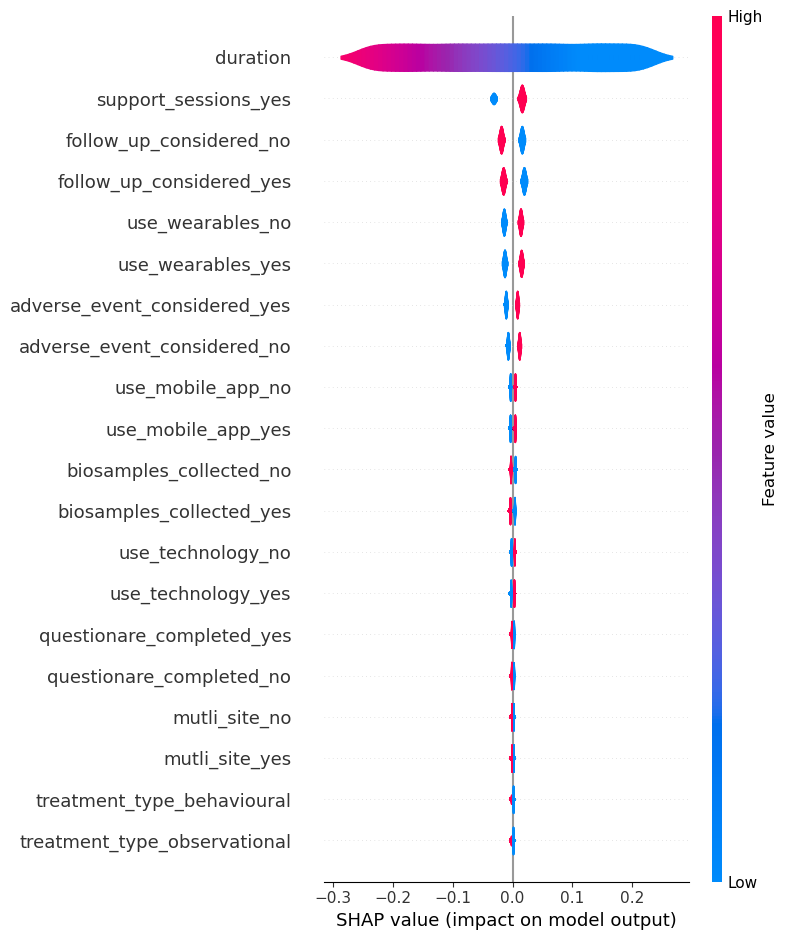

In [21]:
explainer = shap.Explainer(lrg.predict, x_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(x_test)
shap.summary_plot(shap_values, plot_type='violin',feature_names = features)

In [22]:
model = Linear(weights=torch.Tensor(lrg.coef_),bias=torch.ones(1)*lrg.intercept_)

In [33]:
pickle.dump(lrg, open('model-lr', 'wb'))

In [38]:
### an example of query recommendation

x_test_ts = torch.Tensor(x_test.values.astype(np.float32))
y_test_ts = torch.Tensor(y_test.values.astype(np.float32))
query_x = x_test_ts[1].reshape(1,-1)
qy = model(query_x)

torch.save(model.state_dict(), 'model_weights.pth')

In [43]:
query_features = ["n_participant","duration","age>65","male","ethnicity_white"]
target_y = 0.9
query_x.shape[0]

1

In [47]:
cx, cy, cf = query_recommendation(query_x,target_y=torch.ones(query_x.shape[0])*target_y,query_features=query_features,model=model)

[0, 1, 2, 3, 4]


100%|███████████████████████████████████████| 200/200 [00:00<00:00, 2381.92it/s]

iter: 10, loss: 0.042696814984083176
iter: 20, loss: 0.025372454896569252
iter: 30, loss: 0.01348830759525299
iter: 40, loss: 0.006260169204324484
iter: 50, loss: 0.0024498829152435064
iter: 60, loss: 0.0007631683256477118
iter: 70, loss: 0.0001678678090684116
iter: 80, loss: 1.7958704120246693e-05
iter: 90, loss: 1.4915716661789702e-08
iter: 100, loss: 2.8660822408710374e-06
iter: 110, loss: 3.120111159660155e-06
iter: 120, loss: 1.549782496113039e-06
iter: 130, loss: 4.2543479139567353e-07
iter: 140, loss: 4.751274573777664e-08
iter: 150, loss: 2.25611529458547e-10
iter: 160, loss: 8.7459319786376e-09
iter: 170, loss: 7.531525625381619e-09
iter: 180, loss: 2.597122517045136e-09
iter: 190, loss: 3.218794120130042e-10
iter: 200, loss: 1.4210854715202004e-12


In [26]:
cx,cy,cf

(tensor([[0.6496, 0.0927, 0.1822, 0.5078, 0.9783, 0.0000, 1.0000, 0.0000, 1.0000,
          0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000,
          0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000,
          0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000]],
        requires_grad=True),
 tensor([0.9000], grad_fn=<AddBackward0>),
 Index(['duration'], dtype='object'))

In [27]:
query_x,qy

(tensor([[0.6496, 0.5988, 0.1822, 0.5078, 0.9783, 0.0000, 1.0000, 0.0000, 1.0000,
          0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000,
          0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000,
          0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000]]),
 tensor([0.6490]))

In [50]:
cy

tensor([0.9000], grad_fn=<AddBackward0>)